## This notebook is designed to pratice with both geopandas and census data.  This is a simple spatial exploratory analysis of census data. The goal is to assess whether the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.

## THE CENSUS: 
Census data are a national trasure! The census is a survey  designed to collect data on every person that lives in the USA every 10 years. The Census Bureau collects data, designes aggregation areas (the census blocks and tracts for example, which are designed for maximal homogeneity across all features). However, the Census Bureau does not only collect and aggregate data every 10 years, it also collects the America Community Survey every 5 years, and some more restricted survey on an annual bases. The 1 year survey data is what we will use: https://www.census.gov/services/index.html


In [8]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import pylab as pl
#import urllib
import os
import sys
import requests
import json
import io
from shapely.geometry import Point
%matplotlib inline
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
    

ImportError: No module named 'choroplethNYC'

# 1. PUMA : Public Use Microdata Area
Census geographies that are not specific political entities (i.e. states, counties etc) are designed for homogeneity so that aggregating the data over the whole area will leat to an estimat (mean or median for example) with minimal variance. Among these geographies are the _census tracts_, _census blocks_, and _Public Use Microdata Areas (PUMAs)_. PUMAs are geographical areas designed to aggregate census data. Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state.

PUMAs were first created for the 1990 Census. PUMAs are identified by a specific 4 numbers id. In the shapefile foung at data.cityofnewyork.us the id is named "puma" and it is in fact a 4 digits number. You can read it in as an integer (although of course it is a categorical variable inherently!). Often the PUMA id is found in conjunction with the 3 numbers state id, leading to a 7 numbers identification. The id for the State of NY is 036. See this link for more: https://www.census.gov/geo/reference/geoidentifiers.html

## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

downloading it as a shape file. Then unzipping the data into PUIdata directory, reading in the shape file with the function:

        geopandas.GeoDataFrame.from_file(filename)

In [2]:
urllib.urlretrieve('https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile', "file.zip")

('file.zip', <http.client.HTTPMessage at 0x7fb193943f28>)

In [3]:
os.system('mv file.zip ' + os.getenv('PUIDATA'))
print('moved')
os.system('unzip ' + os.getenv('PUIDATA') + '/file.zip ' + '-d ' + os.getenv('PUIDATA'))
print('unzipped')

moved
unzipped


In [4]:
pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA")+"/geo_export_4ba3532c-901b-482f-8312-c00c248ed9e5.shp")

In [5]:
pumashp.head()

,shape_area,shape_leng,puma,geometry
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...


In [6]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2  plot the PUMA NYC regions
 
What is the appropriate plot to just show the shape of the PUMA regions? A choropleth could be ok, but it is better to just draw the contours of the region, since we do not want to highlight some regions over others by color choices. 

(using a function written by Federica, that plots choropleths and maps of NYC specifically putting legends and colorbars in the empty spaces taking advantage of the shape of the city and you are welcome to use it: https://github.com/fedhere/choroplethNYC.)

In [9]:
# using the built in plot function as pumashp.plot(pumashp....)
# pumashp.plot(color="white", edgecolor="black", lw=2);
# using a choroplethNYC function that FBB wrote

import choroplethNYC as cp

cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

ImportError: No module named 'choroplethNYC'

### Figure 1. Boundaries of NYC Public Use Microdata Areas (PUMA) 
Map shows the NYC PUMAs regions

# 2. American Fact Finder data on percentage of houses with broadband internet access

Downloading the table of data from 2016 for NYC: you want to obtain data on broadband access (percentage of households with broadband access) at the PUMA (Public Use Microdata Area) geographical area level. 

This may be tricky. But familiarizing with Census and American Commjunity Survey data is super important for urban science. Here we use the API, but also practice interacting with the website by also downloading the data manually for comparing the two datasets.

## 2.1 Getting data with American Fact Finder (AFF) API: 

Requesting an API key. Saving it into a txt file for further reading in. 

In [10]:
myAPI = open(os.getenv('PUIDATA')+'/census_key.txt','r').read()

In [11]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [12]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())

In [13]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_007EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002

In [14]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [15]:
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [16]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [17]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + "5556edcd724dbca2aa198b6a3ebd7c7279af7f3a"
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generating a feature for the percentage of households with broadband access

In [18]:
pumaBB['B28002_001E'] = pumaPP['B28002_001E']
pumaBB['pcBB'] = pumaBB.B28002_004E / pumaBB.B28002_001E * 100
pumaBB = pumaBB.drop('Unnamed: 4', 1)
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 2.3 Now comparing it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [19]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
                   usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [20]:
bbpc = bbpc.drop(bbpc.index[0])
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


In [21]:
bbpc['GCT_STUB.target-geo-id2'] = bbpc['GCT_STUB.target-geo-id2'].astype(int)
bbpc['gid'] = bbpc['GCT_STUB.target-geo-id2'] - 3600000
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,1,74.7,0.5,-3599999
2,100100,70.9,2.5,-3499900
3,100200,80.5,2.7,-3499800
4,100301,87.0,2.8,-3499699
5,100302,81.9,2.9,-3499698


In [22]:
pumashp.puma = pumashp.puma.astype(int)

In [23]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["state", "gid", "pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,state,gid,pcBB,diff
count,145.0,145.000000,145.000000,145.000000
mean,36.0,2826.827586,81.845478,0.026217
std,0.0,1210.054822,7.063369,0.014480
min,36.0,100.000000,54.932945,0.000178
25%,36.0,1900.000000,77.770257,0.012252
50%,36.0,3208.000000,82.826141,0.027230
75%,36.0,3809.000000,87.305077,0.039090
max,36.0,4114.000000,93.404143,0.049872


In [24]:
pumashp = pumashp.merge(diff_, left_on='puma', right_on='gid')
pumashp.head()

,shape_area,shape_leng,puma,geometry,state,gid,pcBB,HC01,diff
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...,36,3701,84.275820,84.3,0.024180
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...,36,3702,68.310015,68.3,0.010015
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,36,3703,82.826141,82.8,0.026141
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",36,3704,72.553737,72.6,0.046263
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...,36,3705,69.425612,69.4,0.025612


In [25]:
cp.choroplethNYC(pumashp, column='pcBB', cmap='viridis', edgecolor='black');
#pumashp.plot(column='pcBB', cmap='viridis')

NameError: name 'cp' is not defined

### Figure 2. Percentage of Households with Broadband Access in NYC

This choropleth map shows the percentage of NYC households with Broadband access. Yellow areas represent regions with highest percentages. We see that Downtown Manhattan has the most Broadband Access accross NYC. While East Village, marked as dark purple color, has the lowest percentage of Households with Internet Access.


# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

Acquire the linkNYC locations and prepare them into a dataframe
Reading it in from the HW9_fb55 folder in :
https://github.com/fedhere/PUI2017_fb55

In [26]:
linkNYC = pd.read_csv("https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv")
linkNYC = linkNYC.drop('Unnamed: 0', 1)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [27]:
linkNYC.shape

(1414, 4)

In [28]:
import shapely
#turn lat long into shapely points
linkNYC.dropna(axis=0, subset=['latitude','longitude'], inplace=True)
linkNYC['lonlat'] = list(zip(linkNYC.longitude, linkNYC.latitude))
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [29]:
linkNYC = GeoDataFrame(linkNYC, geometry = linkNYC['geometry'])

In [30]:
linkNYC.date_link_ = pd.to_datetime(linkNYC.date_link_)
linkNYC['time'] = pd.datetime.now().date() - linkNYC.date_link_
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry,time
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753),164 days
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938),164 days
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439),164 days
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042),228 days
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133),256 days


Text(0.5,1,'Locations of LinkNYC stations on a Choropleth map of Households with Broadband Access')

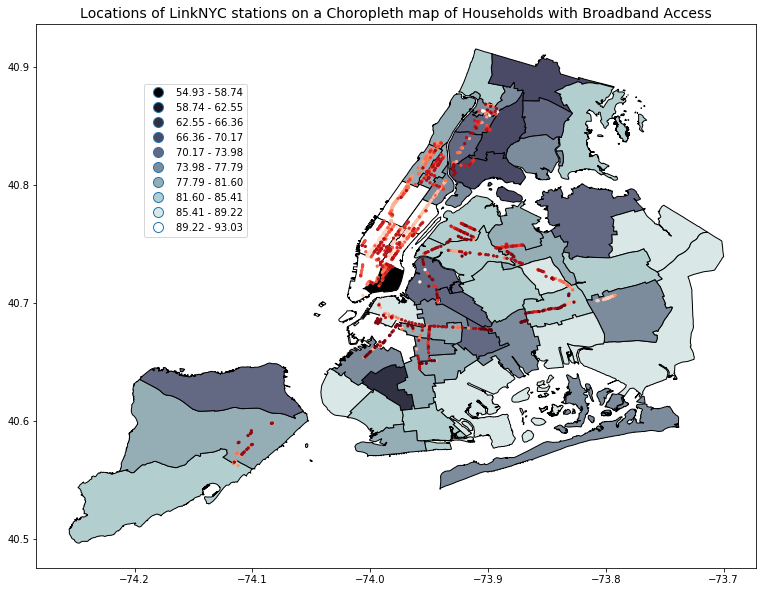

In [31]:
base = pumashp.plot(column='pcBB', cmap='bone', scheme='equal_interval', figsize=(24, 10), k=10,  legend=True, edgecolor='black')
linkNYC.plot(cmap='Reds', ax=base, markersize=5);
leg = base.get_legend()
leg.set_bbox_to_anchor((0.3, 0.9, 0, 0));
base.set_title('Locations of LinkNYC stations on a Choropleth map of Households with Broadband Access', fontsize=14)

### Figure 3. Locations of LinkNYC stations on a Choropleth map of Households with Broadband Access in NYC 

Above map shows the locations of LinkNYC stations across NYC on top of the map with the percentage of the population with Internet access. The legend represents colored areas with equal distribution on groups with the percentages from 54.93% to 93.03%. Stations are color coded with different shades of red by how long ago they have been installed.

# 5 Finding the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS getting the total population by puma and merge it into your GeoDF

In [32]:
keyPopSize = 'B00001_001E'
aff1y['variables'][keyPopSize]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [33]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPopSize +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [34]:
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry,time
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753),164 days
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938),164 days
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439),164 days
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042),228 days
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133),256 days


In [35]:
pumashp.head()

,shape_area,shape_leng,puma,geometry,state,gid,pcBB,HC01,diff
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...,36,3701,84.275820,84.3,0.024180
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...,36,3702,68.310015,68.3,0.010015
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,36,3703,82.826141,82.8,0.026141
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",36,3704,72.553737,72.6,0.046263
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...,36,3705,69.425612,69.4,0.025612


In [36]:
pumashplc = pumashp.merge(pumaPop, left_on='puma', right_on='public use microdata area')
pumashplc.head()

,shape_area,shape_leng,puma,geometry,state_x,gid,pcBB,HC01,diff,B00001_001E,NAME,state_y,public use microdata area,Unnamed: 4
0,9.792852e+07,53227.144357,3701,POLYGON ((-73.89641133483133 40.90450452082026...,36,3701,84.275820,84.3,0.024180,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,1.889860e+08,106050.002507,3702,POLYGON ((-73.86477258283533 40.90201244187379...,36,3702,68.310015,68.3,0.010015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,2.670137e+08,304070.209400,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,36,3703,82.826141,82.8,0.026141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,1.062129e+08,47970.901277,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",36,3704,72.553737,72.6,0.046263,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,1.224950e+08,68630.512052,3705,POLYGON ((-73.88753429505171 40.82250933946978...,36,3705,69.425612,69.4,0.025612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN


In [37]:
len(pumashplc)

55

## 5.2 finding the number of stations per 100 people per PUMA

In [38]:
pumashplc = pumashplc.to_crs(epsg='2263')

In [39]:
linkNYC.crs = {'init': 'epsg:4326'}

In [40]:
linkNYC = linkNYC.to_crs(epsg='2263')

In [41]:
linkpp = gpd.sjoin(pumashplc, linkNYC, how='left').groupby('puma')['link_site'].count().reset_index()
linkpp.head()

#linkpp = gpd.sjoin(linkNYC, pumashplc, how='inner').groupby('puma')[['link_site']].count()
#linkpp.head()

,puma,link_site
0,3701,1
1,3702,0
2,3703,0
3,3704,0
4,3705,1


In [42]:
pumashplc = pumashplc.merge(linkpp, on='puma')
pumashplc.head()

,shape_area,shape_leng,puma,geometry,state_x,gid,pcBB,HC01,diff,B00001_001E,NAME,state_y,public use microdata area,Unnamed: 4,link_site
0,9.792852e+07,53227.144357,3701,"POLYGON ((1012885.033996583 268830.4841918442,...",36,3701,84.275820,84.3,0.024180,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,1
1,1.889860e+08,106050.002507,3702,"POLYGON ((1021632.335632326 267934.4393920284,...",36,3702,68.310015,68.3,0.010015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,0
2,2.670137e+08,304070.209400,3703,(POLYGON ((1042822.450195312 243439.8142089319...,36,3703,82.826141,82.8,0.026141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,0
3,1.062129e+08,47970.901277,3704,"POLYGON ((1026308.769592285 256767.6972045382,...",36,3704,72.553737,72.6,0.046263,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,0
4,1.224950e+08,68630.512052,3705,"POLYGON ((1015377.269592287 238959.501403747, ...",36,3705,69.425612,69.4,0.025612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,1


In [43]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"] = (pumashplc['link_site'] / pumashplc['B00001_001E']) * 100
#pumashplc['linkNYCp100p'] = pumashplc.B00001_001E / ( 100 * pumashplc.link_site)
pumashplc["linkNYCp100p"].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

In [44]:
pumashplc.head()

,shape_area,shape_leng,puma,geometry,state_x,gid,pcBB,HC01,diff,B00001_001E,NAME,state_y,public use microdata area,Unnamed: 4,link_site,linkNYCp100p
0,9.792852e+07,53227.144357,3701,"POLYGON ((1012885.033996583 268830.4841918442,...",36,3701,84.275820,84.3,0.024180,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,1,0.065920
1,1.889860e+08,106050.002507,3702,"POLYGON ((1021632.335632326 267934.4393920284,...",36,3702,68.310015,68.3,0.010015,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,0,0.000000
2,2.670137e+08,304070.209400,3703,(POLYGON ((1042822.450195312 243439.8142089319...,36,3703,82.826141,82.8,0.026141,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,0,0.000000
3,1.062129e+08,47970.901277,3704,"POLYGON ((1026308.769592285 256767.6972045382,...",36,3704,72.553737,72.6,0.046263,1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,0,0.000000
4,1.224950e+08,68630.512052,3705,"POLYGON ((1015377.269592287 238959.501403747, ...",36,3705,69.425612,69.4,0.025612,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,1,0.049727


Text(0.5,1,'Locations of LinkNYC stations on a Choropleth map of number of stations per 100 people')

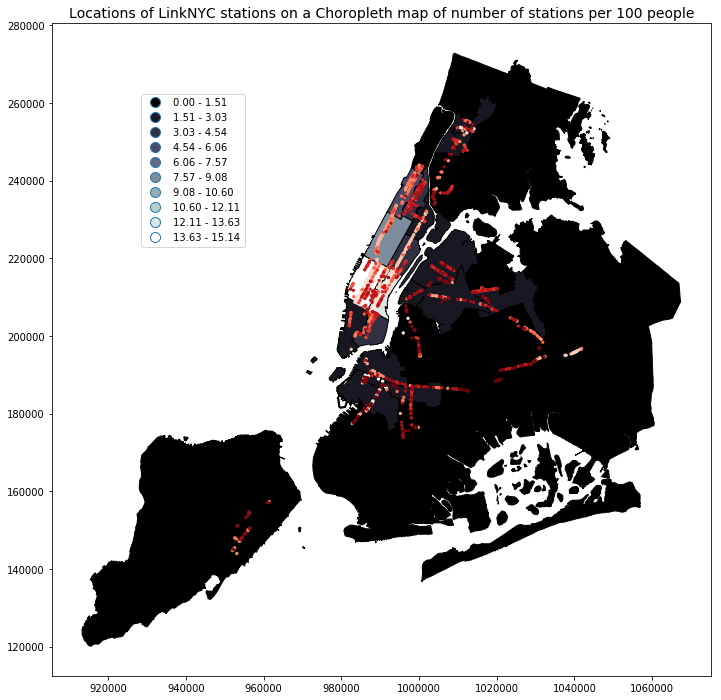

In [45]:
base = pumashplc.plot(column='linkNYCp100p', cmap='bone',
                      scheme='equal_interval', k=10, figsize=(12,12), legend=True, edgecolor='black',)
linkNYC.plot(ax=base, cmap='Reds', markersize=5);
leg = base.get_legend()
leg.set_bbox_to_anchor((0.3, 0.9, 0, 0));
base.set_title('Locations of LinkNYC stations on a Choropleth map of number of stations per 100 people', fontsize=14)

### Figure 4. LinkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

Since most of the areas do not have the LinkNYC stations, it is hard to read the map. Still we can notice that Midtown and Downtown Manhattan have highest percentage of LinkNYC stations per 100 people.

# Extra credit 1: 
In order to enhance the visibility of the Figure 4 we can change the shading to provide better analysis. We are working with numbers that are mostly very low, and reside near each other. Also there are high values that should not be excluded. 
The idea is to experiment with Choroplenth map, with scheme explicitly. Division by equal intervals is not informative. Therefore it was decided to use quantiles instead. 

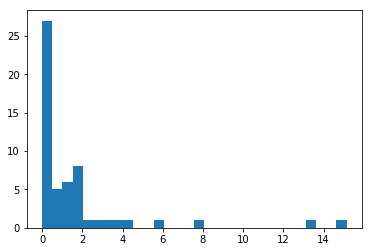

In [46]:
pl.hist(pumashplc["linkNYCp100p"], bins=30);

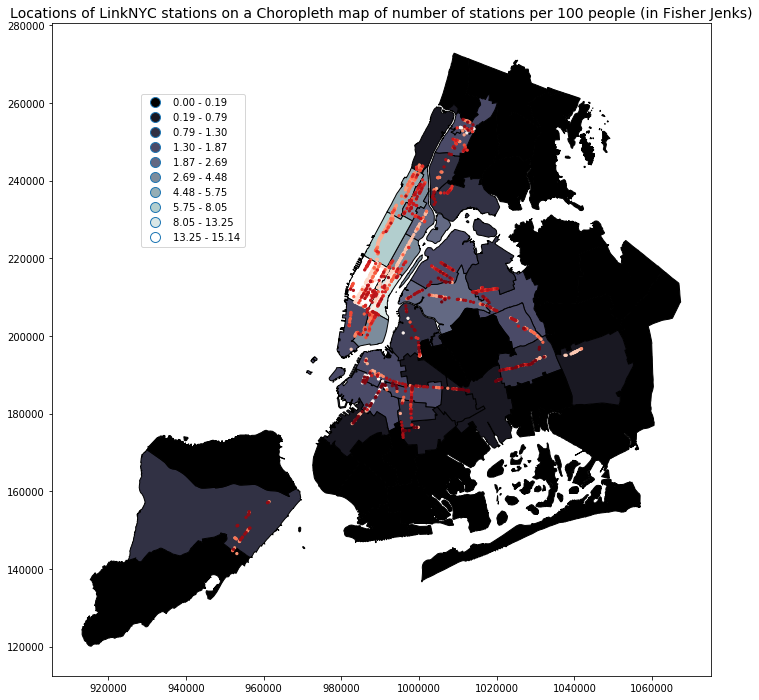

In [47]:
base = pumashplc.plot(column='linkNYCp100p', cmap='bone',
                      scheme='fisher_jenks', k=10, figsize=(12,12), legend=True, edgecolor='black')
linkNYC.plot(ax=base, cmap='Reds', markersize=5);
leg = base.get_legend()
leg.set_bbox_to_anchor((0.3, 0.9, 0, 0));
base.set_title('Locations of LinkNYC stations on a Choropleth map of number of stations per 100 people (in Fisher Jenks)', fontsize=14);

### Figure 5. LinkNYC locations on top of a choropleth of number of stations per 100 people in Fisher Jenks
Compared to the Figure 4, data classification scheme by Fisher Jenks provides more informative map. Now we can observe the variation in internet access accross more NYC areas. But still there are dark areas which can not be distinguished. 

Let us try data classification scheme in quantiles:

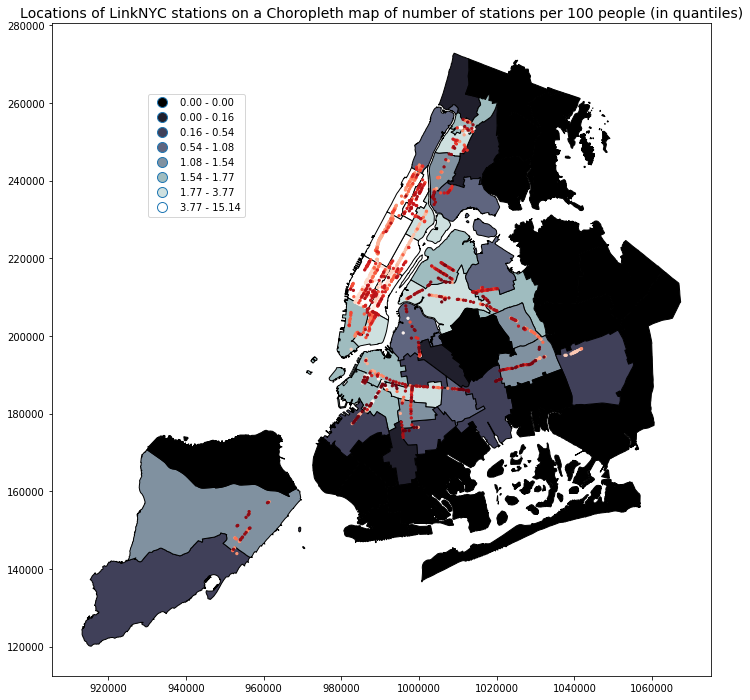

In [48]:
base = pumashplc.plot(column='linkNYCp100p', cmap='bone',
                      scheme='quantiles', k=10, figsize=(12,12), legend=True, edgecolor='black')
linkNYC.plot(ax=base, cmap='Reds', markersize=5);
leg = base.get_legend()
leg.set_bbox_to_anchor((0.3, 0.9, 0, 0));
base.set_title('Locations of LinkNYC stations on a Choropleth map of number of stations per 100 people (in quantiles)', fontsize=14);

### Figure 6. LinkNYC locations on top of a choropleth of number of stations per 100 people in quantiles
Compared to the Figure 5, data classification scheme by quantiles provides information. Therefore we can conclude that quantiles scheme suits best for the data representation. We can now better see Staten Island borough distribution.

## ASH Score 100. Extra Credit 50